# Regresiones

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Resultado del mes anterior

In [2]:
imacec = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/BC%20Imacec.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
imacec.columns = ['imacec']
imacec.tail()

,imacec
Fecha,
2021-05-01,19.183195
2021-06-01,20.607161
2021-07-01,18.075599
2021-08-01,19.075623
2021-09-01,15.567727


In [4]:
# ACTUALIZAR nombre de documento
prediccion = pd.read_csv('pred_2021_10.csv', index_col=0)
prediccion

,prediccion
percepcion,
IPECO,3.122950
IPEC,2.324444
ICE,7.692718
IMCE,7.828019
Consumidores,2.080422
Empresarios,9.065080
Todos,12.661902


In [5]:
prediccion['imacec'] = imacec['imacec'][-1]
prediccion['abs-error'] = np.abs(prediccion['prediccion'] - prediccion['imacec'])
prediccion.sort_values('abs-error')

,prediccion,imacec,abs-error
percepcion,,,
Todos,12.661902,15.567727,2.905825
Empresarios,9.065080,15.567727,6.502647
IMCE,7.828019,15.567727,7.739708
ICE,7.692718,15.567727,7.875008
IPECO,3.122950,15.567727,12.444777
IPEC,2.324444,15.567727,13.243282
Consumidores,2.080422,15.567727,13.487305


In [6]:
prediccion = prediccion.sort_values('abs-error')
prediccion['ranking'] = np.arange(1,8,1)

In [7]:
# ACTUALIZAR nombre de documento
prediccion.to_csv('res_2021_10.csv')
prediccion.round(2)

,prediccion,imacec,abs-error,ranking
percepcion,,,,
Todos,12.66,15.57,2.91,1
Empresarios,9.07,15.57,6.50,2
IMCE,7.83,15.57,7.74,3
ICE,7.69,15.57,7.88,4
IPECO,3.12,15.57,12.44,5
IPEC,2.32,15.57,13.24,6
Consumidores,2.08,15.57,13.49,7


In [8]:
# ACTUALIZAR nombre
ranking_actual = prediccion[['ranking']]
ranking_actual.columns = ['R-2021-10']

ranking_acumulado = pd.read_csv('ranking_acumulado.csv', index_col='percepcion')
ranking_acumulado = pd.concat([ranking_acumulado, ranking_actual], axis=1)
ranking_acumulado.to_csv('ranking_acumulado.csv')
ranking_acumulado

,R-2011-05,R-2021-06,R-2021-07,R-2021-08,R-2021-09,R-2021-10
percepcion,,,,,,
IMCE,1,4,4,2,3,3
ICE,2,2,2,4,4,4
Empresarios,3,3,3,1,1,2
IPECO,4,7,7,5,6,5
Todos,5,1,1,3,2,1
Consumidores,6,5,5,6,7,7
IPEC,7,6,6,7,5,6


In [9]:
# Ranking promedio
ranking_acumulado.mean(axis=1).sort_values().round(1)

percepcion
Empresarios     2.2
Todos           2.2
IMCE            2.8
ICE             3.0
IPECO           5.7
Consumidores    6.0
IPEC            6.2
dtype: float64

In [10]:
# Número de victorias
(ranking_acumulado == 1).sum(axis=1).sort_values(ascending=False)

percepcion
Todos           3
Empresarios     2
IMCE            1
ICE             0
IPECO           0
Consumidores    0
IPEC            0
dtype: int64

# Carga y Preprocesamiento de los datos de percepciones

In [11]:
ipeco = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/CEEN%20UDD%20IPECO.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
ipeco.columns = ['ipeco', 'coyuntura', 'expectativas', 'ipeco-sea', 'ipeco-da', 'ipeco-sef', 'ipeco-df', 'ipeco-if', 'ipeco-m3']
ipeco = ipeco[['ipeco', 'ipeco-sea', 'ipeco-da', 'ipeco-sef', 'ipeco-df', 'ipeco-if']]
ipeco.tail()

,ipeco,ipeco-sea,ipeco-da,ipeco-sef,ipeco-df,ipeco-if
Fecha,,,,,,
2021-06-01,78.879765,80.526228,79.308283,83.715502,82.139328,71.945701
2021-07-01,87.510065,79.257448,139.571906,79.083470,105.280749,74.986264
2021-08-01,81.638968,76.237704,146.820465,72.546328,86.335920,72.195513
2021-09-01,92.280043,88.003663,159.597619,76.303192,116.461577,75.952293
2021-10-01,84.645442,79.757544,154.462941,80.805932,106.818182,57.083541


In [12]:
ipeco['ipeco-m3'] = ipeco['ipeco'].rolling(3).mean()
ipeco['ipeco-m6'] = ipeco['ipeco'].rolling(6).mean()
ipeco['ipeco-presente'] = ipeco[['ipeco-sea', 'ipeco-da']].mean(axis=1)
ipeco['ipeco-futuro'] = ipeco[['ipeco-sef', 'ipeco-df', 'ipeco-if']].mean(axis=1)
ipeco['ipeco-personal'] = ipeco[['ipeco-sea', 'ipeco-sef', 'ipeco-if']].mean(axis=1)
ipeco['ipeco-nacional'] = ipeco[['ipeco-df', 'ipeco-da']].mean(axis=1)
ipeco.tail()

,ipeco,ipeco-sea,ipeco-da,ipeco-sef,ipeco-df,ipeco-if,ipeco-m3,ipeco-m6,ipeco-presente,ipeco-futuro,ipeco-personal,ipeco-nacional
Fecha,,,,,,,,,,,,
2021-06-01,78.879765,80.526228,79.308283,83.715502,82.139328,71.945701,69.140239,74.302472,79.917255,79.266844,78.729144,80.723806
2021-07-01,87.510065,79.257448,139.571906,79.083470,105.280749,74.986264,80.893995,77.063823,109.414677,86.450161,77.775727,122.426327
2021-08-01,81.638968,76.237704,146.820465,72.546328,86.335920,72.195513,82.676266,76.188629,111.529084,77.025920,73.659848,116.578192
2021-09-01,92.280043,88.003663,159.597619,76.303192,116.461577,75.952293,87.143026,78.141632,123.800641,89.572354,80.086383,138.029598
2021-10-01,84.645442,79.757544,154.462941,80.805932,106.818182,57.083541,86.188151,83.541073,117.110243,81.569218,72.549006,130.640561


In [13]:
ipec = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/GFK%20ADIMARK%20IPEC.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
ipec.columns = ['ipec-sepa', 'ipec-sena', 'ipec-senf12m', 'ipec-senf5y', 'ipec-ec', 'ipec']
ipec.tail()

,ipec-sepa,ipec-sena,ipec-senf12m,ipec-senf5y,ipec-ec,ipec
Fecha,,,,,,
2021-06-01,33.079220,34.198383,43.743576,23.450972,32.484848,33.391399
2021-07-01,35.453369,38.337109,45.344166,30.438742,37.478245,37.410324
2021-08-01,41.927624,40.358204,46.427765,30.081245,37.857059,39.330379
2021-09-01,40.188671,41.584583,44.678387,26.695692,36.160355,37.861538
2021-10-01,36.233318,35.555622,38.466400,26.122946,34.787159,34.233089


In [14]:
ipec['ipec-m3'] = ipec['ipec'].rolling(3).mean()
ipec['ipec-m6'] = ipec['ipec'].rolling(6).mean()
ipec['ipec-presente'] = ipec[['ipec-sepa', 'ipec-sena', 'ipec-ec']].mean(axis=1)
ipec['ipec-futuro'] = ipec[['ipec-senf12m', 'ipec-senf5y']].mean(axis=1)
ipec['ipec-personal'] = ipec[['ipec-sepa', 'ipec-ec']].mean(axis=1)
ipec['ipec-nacional'] = ipec[['ipec-sena', 'ipec-senf12m', 'ipec-senf5y']].mean(axis=1)
ipec.tail()

,ipec-sepa,ipec-sena,ipec-senf12m,ipec-senf5y,ipec-ec,ipec,ipec-m3,ipec-m6,ipec-presente,ipec-futuro,ipec-personal,ipec-nacional
Fecha,,,,,,,,,,,,
2021-06-01,33.079220,34.198383,43.743576,23.450972,32.484848,33.391399,29.374371,29.795894,33.254150,33.597274,32.782034,33.797644
2021-07-01,35.453369,38.337109,45.344166,30.438742,37.478245,37.410324,33.544317,31.116071,37.089574,37.891454,36.465807,38.040005
2021-08-01,41.927624,40.358204,46.427765,30.081245,37.857059,39.330379,36.710701,32.342151,40.047629,38.254505,39.892342,38.955738
2021-09-01,40.188671,41.584583,44.678387,26.695692,36.160355,37.861538,38.200747,33.787559,39.311203,35.687039,38.174513,37.652887
2021-10-01,36.233318,35.555622,38.466400,26.122946,34.787159,34.233089,37.141669,35.342993,35.525366,32.294673,35.510239,33.381656


In [15]:
ice = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/CEEN%20UDD%20ICE.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
ice.columns = ['ice', 'ice-m3', 'ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']
ice = ice[['ice', 'ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']]
ice.tail()

,ice,ice-agricola,ice-comercio,ice-construccion,ice-financiero,ice-industria,ice-mineria
Fecha,,,,,,,
2021-06-01,5.280328,17.005348,6.336682,-4.180036,0.00,20.718254,-6.079861
2021-07-01,7.064368,-23.529412,10.916034,11.419786,-25.00,30.099206,1.333333
2021-08-01,6.373340,-17.647059,11.488691,4.823529,-6.25,18.973214,2.666667
2021-09-01,6.847542,-31.250000,10.299901,-11.739750,12.50,9.358825,19.805556
2021-10-01,-1.814161,-35.294118,8.994236,-11.574866,18.75,-3.078373,-4.583333


In [16]:
ice['ice-m'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-m3'] = ice['ice'].rolling(3).mean()
ice['ice-m6'] = ice['ice'].rolling(6).mean()
ice['ice-sagri'] = ice[['ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-scom'] = ice[['ice-agricola', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-scons'] = ice[['ice-agricola', 'ice-comercio', 'ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-sfin'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-sind'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-mineria']].mean(axis=1)
ice['ice-smin'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria']].mean(axis=1)
ice.tail()

,ice,ice-agricola,ice-comercio,ice-construccion,ice-financiero,ice-industria,ice-mineria,ice-m,ice-m3,ice-m6,ice-sagri,ice-scom,ice-scons,ice-sfin,ice-sind,ice-smin
Fecha,,,,,,,,,,,,,,,,
2021-06-01,5.280328,17.005348,6.336682,-4.180036,0.00,20.718254,-6.079861,5.633398,0.900362,3.360555,3.359008,5.492741,7.596084,6.760077,2.616427,7.976050
2021-07-01,7.064368,-23.529412,10.916034,11.419786,-25.00,30.099206,1.333333,0.873158,4.425090,4.262512,5.753672,-1.135417,-1.236168,6.047790,-4.972052,0.781123
2021-08-01,6.373340,-17.647059,11.488691,4.823529,-6.25,18.973214,2.666667,2.342507,6.239345,3.822293,6.340420,0.513270,1.846303,4.061009,-0.983634,2.277675
2021-09-01,6.847542,-31.250000,10.299901,-11.739750,12.50,9.358825,19.805556,1.495755,6.761750,3.831056,8.044906,-0.265074,4.142856,-0.705094,-0.076859,-2.166205
2021-10-01,-1.814161,-35.294118,8.994236,-11.574866,18.75,-3.078373,-4.583333,-4.464409,3.802240,4.113665,1.701533,-7.156138,-3.042318,-9.107291,-4.741616,-4.440624


In [17]:
imce = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/ICARE%20UAI%20IMCE.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
imce.columns = ['imce-comercio', 'imce-construccion', 'imce-industria', 'imce-mineria', 'imce', 'imce-sm']
imce = imce[['imce-comercio', 'imce-construccion', 'imce-industria', 'imce-mineria', 'imce']]
imce.tail()

,imce-comercio,imce-construccion,imce-industria,imce-mineria,imce
Fecha,,,,,
2021-06-01,55.263158,42.391304,55.882353,61.676281,54.331456
2021-07-01,59.821429,43.359375,61.309524,61.399973,57.640541
2021-08-01,61.695906,51.515152,62.944984,62.012282,60.345786
2021-09-01,61.214953,56.439394,61.904762,61.676281,60.679626
2021-10-01,57.971014,48.106061,59.327217,66.149513,58.203213


In [18]:
imce['imce-m'] = imce[['imce-comercio', 'imce-construccion', 'imce-industria', 'imce-mineria']].mean(axis=1)
imce['imce-m3'] = imce['imce'].rolling(3).mean()
imce['imce-m6'] = imce['imce'].rolling(6).mean()
imce['imce-scom'] = imce[['imce-construccion', 'imce-industria', 'imce-mineria']].mean(axis=1)
imce['imce-scons'] = imce[['imce-comercio', 'imce-industria', 'imce-mineria']].mean(axis=1)
imce['imce-sind'] = imce[['imce-comercio', 'imce-construccion', 'imce-mineria']].mean(axis=1)
imce['imce-smin'] = imce[['imce-comercio', 'imce-construccion', 'imce-industria']].mean(axis=1)
imce.tail()

,imce-comercio,imce-construccion,imce-industria,imce-mineria,imce,imce-m,imce-m3,imce-m6,imce-scom,imce-scons,imce-sind,imce-smin
Fecha,,,,,,,,,,,,
2021-06-01,55.263158,42.391304,55.882353,61.676281,54.331456,53.803274,53.543857,54.434682,53.316646,57.607264,53.110248,51.178938
2021-07-01,59.821429,43.359375,61.309524,61.399973,57.640541,56.472575,55.618473,54.978165,55.356291,60.843642,54.860259,54.830109
2021-08-01,61.695906,51.515152,62.944984,62.012282,60.345786,59.542081,57.439261,55.748843,58.824139,62.217724,58.407780,58.718681
2021-09-01,61.214953,56.439394,61.904762,61.676281,60.679626,60.308848,59.555318,56.549587,60.006812,61.598665,59.776876,59.853036
2021-10-01,57.971014,48.106061,59.327217,66.149513,58.203213,57.888451,59.742875,57.680674,57.860930,61.149248,57.408863,55.134764


In [19]:
encuesta = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/BC%20EEE%20PIB%20e%20IMACEC.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
encuesta = encuesta[['IMACEC un mes atrás']]
encuesta.columns = ['encuesta-imacec']
encuesta['encuesta-imacec'] = encuesta['encuesta-imacec'].shift(-1)
encuesta.tail()

,encuesta-imacec
Fecha,
2021-07-01,16.3
2021-08-01,16.3
2021-09-01,13.3
2021-10-01,12.5
2021-11-01,NaN


In [20]:
data = pd.concat([imacec, ipeco, ipec, ice, imce], axis=1)
print(data.shape)

(310, 53)


# Preprocesamiento, funciones y dataframes para guardar los resultados

In [21]:
# Función para calcular las métricas de evaluación. 
def get_metrics(indice, y_test, y_pred):
    return pd.DataFrame({
                'CV_RMSE': np.sqrt(np.abs(searcher.best_score_)),
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'MAE': mean_absolute_error(y_test, y_pred),
                'R2': r2_score(y_test, y_pred)},
                index=[indice])

In [22]:
# DataFrames vacíos para almacenar los resultados 
results = pd.DataFrame()
samples = pd.DataFrame()
predicciones = pd.DataFrame()

In [23]:
# Variables X e y
X = data.drop(['imacec'], axis=1)
y = data['imacec']

In [24]:
# Train y Test sets
X_train0 = X.iloc[:-1]
X_test0 = X.iloc[[-1]]
y_train0 = y.iloc[:-1]

print(
    'X_train shape:', X_train0.shape,
    'X_test shape:', X_test0.shape,
    'y_train shape:', y_train0.shape)

X_train shape: (309, 52) X_test shape: (1, 52) y_train shape: (309,)


In [25]:
def gen_X_train(variables):
    X_train = X_train0[variables].dropna()
    X_test = X_test0[variables]
    y_train = y_train0[X_train.index]
    print('X_train shape:', X_train.shape, '||', 'X_test shape:', X_test.shape, '||', 'y_train shape:', y_train.shape)

    return X_train, X_test, y_train

In [26]:
# Variables de cada modelo
vipeco = ipeco.columns
vipec = ipec.columns
vice = ice.columns
vimce = imce.columns
vconsumidores = ipeco.columns.append(ipec.columns)
vempresarios = ice.columns.append(imce.columns)

# IPECO

In [27]:
indice = 'IPECO'
X_train, X_test, y_train = gen_X_train(vipeco)

X_train shape: (206, 12) || X_test shape: (1, 12) || y_train shape: (206,)


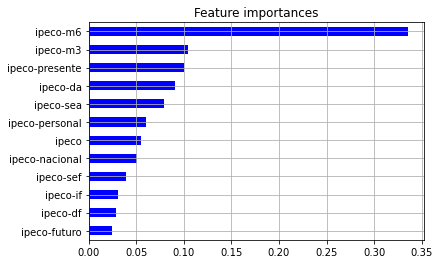

X_train shape: (206, 6) || X_test shape: (1, 6) || y_train shape: (206,)
['ipeco-personal' 'ipeco-sea' 'ipeco-da' 'ipeco-presente' 'ipeco-m3'
 'ipeco-m6']


In [28]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [29]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[10:58:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,4.8054,1.6197,1.1679,0.8737


# IPEC

In [30]:
indice = 'IPEC'
X_train, X_test, y_train = gen_X_train(vipec)

X_train shape: (230, 12) || X_test shape: (1, 12) || y_train shape: (230,)


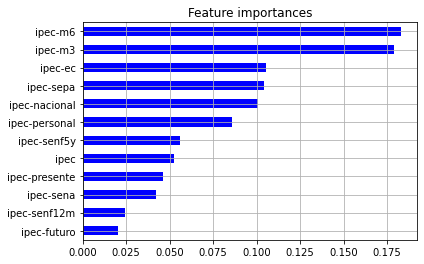

X_train shape: (230, 6) || X_test shape: (1, 6) || y_train shape: (230,)
['ipec-personal' 'ipec-nacional' 'ipec-sepa' 'ipec-ec' 'ipec-m3' 'ipec-m6']


In [31]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [32]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[10:58:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 1.0, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 200}


,CV_RMSE,RMSE,MAE,R2
IPECO,4.8054,1.6197,1.1679,0.8737
IPEC,4.6314,1.3991,1.0221,0.8988


# ICE

In [33]:
indice = 'ICE'
X_train, X_test, y_train = gen_X_train(vice)

X_train shape: (195, 16) || X_test shape: (1, 16) || y_train shape: (195,)


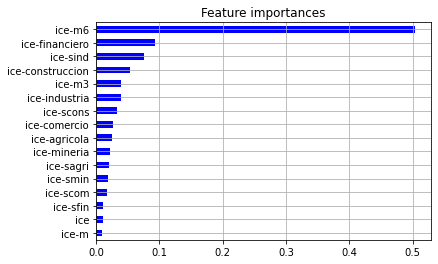

X_train shape: (197, 8) || X_test shape: (1, 8) || y_train shape: (197,)
['ice-comercio' 'ice-scons' 'ice-industria' 'ice-m3' 'ice-construccion'
 'ice-sind' 'ice-financiero' 'ice-m6']


In [34]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [35]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[10:58:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 1.0, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,4.8054,1.6197,1.1679,0.8737
IPEC,4.6314,1.3991,1.0221,0.8988
ICE,3.9797,1.3467,0.9243,0.9148


# IMCE

In [36]:
indice = 'IMCE'
X_train, X_test, y_train = gen_X_train(vimce)

X_train shape: (210, 12) || X_test shape: (1, 12) || y_train shape: (210,)


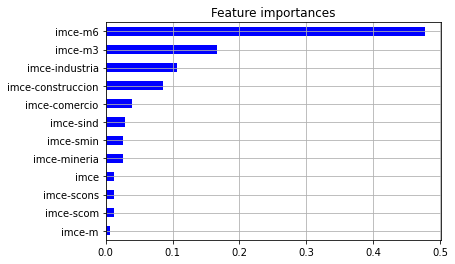

X_train shape: (210, 6) || X_test shape: (1, 6) || y_train shape: (210,)
['imce-sind' 'imce-comercio' 'imce-construccion' 'imce-industria'
 'imce-m3' 'imce-m6']


In [37]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [38]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[10:58:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,4.8054,1.6197,1.1679,0.8737
IPEC,4.6314,1.3991,1.0221,0.8988
ICE,3.9797,1.3467,0.9243,0.9148
IMCE,4.0231,1.3742,0.9401,0.9105


# Confianza de los consumidores

In [39]:
indice = 'Consumidores'
X_train, X_test, y_train = gen_X_train(vconsumidores)

X_train shape: (206, 24) || X_test shape: (1, 24) || y_train shape: (206,)


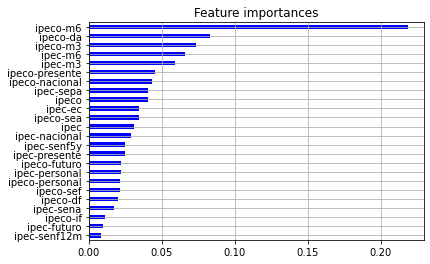

X_train shape: (206, 12) || X_test shape: (1, 12) || y_train shape: (206,)
['ipec' 'ipeco-sea' 'ipec-ec' 'ipeco' 'ipec-sepa' 'ipeco-nacional'
 'ipeco-presente' 'ipec-m3' 'ipec-m6' 'ipeco-m3' 'ipeco-da' 'ipeco-m6']


In [40]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [41]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[10:58:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,4.8054,1.6197,1.1679,0.8737
IPEC,4.6314,1.3991,1.0221,0.8988
ICE,3.9797,1.3467,0.9243,0.9148
IMCE,4.0231,1.3742,0.9401,0.9105
Consumidores,4.7953,1.2243,0.8871,0.9279


# Confianza empresarial

In [42]:
indice = 'Empresarios'
X_train, X_test, y_train = gen_X_train(vempresarios)

X_train shape: (195, 28) || X_test shape: (1, 28) || y_train shape: (195,)


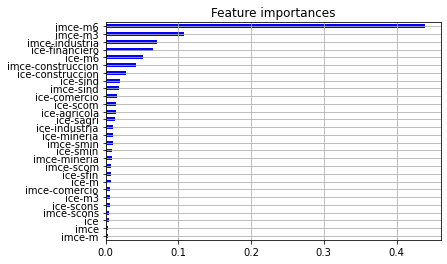

X_train shape: (195, 14) || X_test shape: (1, 14) || y_train shape: (195,)
['ice-industria' 'ice-sagri' 'ice-agricola' 'ice-scom' 'ice-comercio'
 'imce-sind' 'ice-sind' 'ice-construccion' 'imce-construccion' 'ice-m6'
 'ice-financiero' 'imce-industria' 'imce-m3' 'imce-m6']


In [43]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [44]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[10:58:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 2, 'min_child_weight': 12, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,4.8054,1.6197,1.1679,0.8737
IPEC,4.6314,1.3991,1.0221,0.8988
ICE,3.9797,1.3467,0.9243,0.9148
IMCE,4.0231,1.3742,0.9401,0.9105
Consumidores,4.7953,1.2243,0.8871,0.9279
Empresarios,4.1193,1.6570,1.1782,0.8719


# Todos los índices

In [45]:
indice = 'Todos'
X_train, X_test, y_train = gen_X_train(X_train0.columns)

X_train shape: (195, 52) || X_test shape: (1, 52) || y_train shape: (195,)


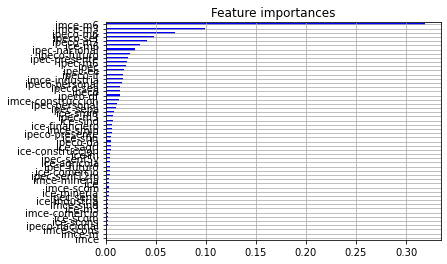

X_train shape: (197, 26) || X_test shape: (1, 26) || y_train shape: (197,)
['imce-smin' 'ice-financiero' 'ice-sind' 'ipec-m3' 'ice-smin' 'ipec-sepa'
 'ipec-personal' 'imce-construccion' 'ipeco-df' 'ipeco' 'ipeco-sea'
 'ipeco-personal' 'imce-industria' 'ipeco-if' 'ipec-ec' 'ipec' 'ipec-m6'
 'ipec-presente' 'ipeco-futuro' 'ipec-nacional' 'ice-m6' 'ipeco-m3'
 'ipeco-sef' 'ipeco-m6' 'imce-m3' 'imce-m6']


In [46]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [47]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[10:59:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 1.0, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,4.8054,1.6197,1.1679,0.8737
IPEC,4.6314,1.3991,1.0221,0.8988
ICE,3.9797,1.3467,0.9243,0.9148
IMCE,4.0231,1.3742,0.9401,0.9105
Consumidores,4.7953,1.2243,0.8871,0.9279
Empresarios,4.1193,1.6570,1.1782,0.8719
Todos,3.6591,0.6488,0.4972,0.9802


# Evaluación según resultados en CV y train set

In [48]:
samples

,rows,cols
IPECO,206,6
IPEC,230,6
ICE,197,8
IMCE,210,6
Consumidores,206,12
Empresarios,195,14
Todos,197,26


In [49]:
results['Ratio'] = (results['CV_RMSE'] / results['RMSE']).round(2)
print('Best models:')
print(results[['CV_RMSE', 'RMSE', 'MAE', 'Ratio']].idxmin(), '\n')
print('Best R2:')
print(results[['R2']].idxmax(), '\n')
results.round(2)

Best models:
CV_RMSE          Todos
RMSE             Todos
MAE              Todos
Ratio      Empresarios
dtype: object 

Best R2:
R2    Todos
dtype: object 



,CV_RMSE,RMSE,MAE,R2,Ratio
IPECO,4.81,1.62,1.17,0.87,2.97
IPEC,4.63,1.40,1.02,0.90,3.31
ICE,3.98,1.35,0.92,0.91,2.96
IMCE,4.02,1.37,0.94,0.91,2.93
Consumidores,4.80,1.22,0.89,0.93,3.92
Empresarios,4.12,1.66,1.18,0.87,2.49
Todos,3.66,0.65,0.50,0.98,5.64


In [50]:
predicciones = predicciones.reset_index()
predicciones.columns = ['percepcion', 'prediccion']
predicciones.round(2)

,percepcion,prediccion
0,IPECO,5.64
1,IPEC,5.40
2,ICE,7.80
3,IMCE,7.79
4,Consumidores,2.85
5,Empresarios,10.75
6,Todos,12.91


In [51]:
print('Mayor predicción:')
print(predicciones['prediccion'].idxmax(), '\n')

print('Menor predicción:')
print(predicciones['prediccion'].idxmin(), '\n')

Mayor predicción:
6 

Menor predicción:
4 



In [52]:
print('Predicción de la encuesta de expectativas económicas:')
pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/BC%20EEE%20PIB%20e%20IMACEC.csv', index_col='Fecha')['IMACEC un mes atrás'].tail(1)

Predicción de la encuesta de expectativas económicas:


Fecha
01-11-2021    12.5
Name: IMACEC un mes atrás, dtype: float64

In [53]:
# ACTUALIZAR nombre de documento
predicciones.to_csv('pred_2021_11.csv', index=False)